<a href="https://colab.research.google.com/github/BCI-and-Neuroergonomics-Lab/3D-MB-CNN/blob/dev/SEED_Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [ ]:
# Loading your drive so CoLab has access to it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [ ]:
import os, sys, re
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob

Constants


In [ ]:
# Data Processing Mode ('3D' or '2D')

MODE = '3D'

# File Patterns for Data Files

FILE_PATTERN = "_*.mat"
SUFFIX_3D_DIRS = "_3d/"
SUFFIX_2D_DIRS = "_2d/"

# Data Directories
DEFAULT_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV/eeg_raw_data/"

PROCESSED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_processed"

CROPPED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_cropped"

AVERAGED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_averaged"

SHUFFLED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_shuffled"

# Data Split

TRAIN_DIR_APPEND = "train/"

VAL_DIR_APPEND = "val/"

TEST_DIR_APPEND = "test/"

SPLIT_TYPES = ('train', 'test', 'val')
SPLIT_DIR_DICT = {'train': TRAIN_DIR_APPEND, 'test': TEST_DIR_APPEND, 'val': VAL_DIR_APPEND}

# Split Ratios, results in a 60/20/20 split
# First data is split between training and val/test
# Second val/test is split into val and test
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.5

SHUFFLE_SPLITS = True

# Data Processing Parameters

# Initial time window extracted from raw data
WINDOW = 3
# Length of self-assessment following video
SA_DUR = 45
# Data frequency
FREQ = 200
# Number of classes
NUM_CLASSES = 4
# Number of subjects
NUM_SUBJECTS = 15
# Number of different sessions
NUM_SESSIONS = 3
# Number of trials in each session
TRIALS_PER_SESSION = 24
# X dim of 3D data
X_DIM_3D = 7
# Y dim of 3D data
Y_DIM_3D = 6
# Window size post cropping
WINDOW_SIZE = 313
# Step size while cropping
STEP_SIZE = 20
# Which channels are included, matched with BCICIV_2a dataset channels
INCLUDE = (9, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 37, 38, 44, 45, 46, 52)
# Labels for dataset trials
LABELS = {1:(1, 2, 3, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 3, 2, 2, 3, 3, 0, 3, 0, 3), 2:(2, 1, 3, 0, 0, 2, 0, 2, 3, 3, 2, 3, 2, 0, 1, 1, 2, 1, 0, 3, 0, 1, 3, 1), 3:(1, 2, 2, 1, 3, 3, 3, 1, 1, 2, 1, 0, 2, 3, 3, 0, 2, 3, 0, 0, 2, 0, 1, 0)} 

Data Processing Class

In [ ]:
class DataProcessing:
  def __init__(self, data_dir=DEFAULT_DIR, mode='3D'):
    if (mode != '3D' and mode != '2D'):
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    self.dim = mode
    self.data_files = {}
    self.data_file_counts = {}
    for subject in range(1, NUM_SUBJECTS+1):
      self.data_files[subject] = []
      for session in range(1, NUM_SESSIONS+1):
        data_files_pattern = data_dir + str(session) + "/" + str(subject) + FILE_PATTERN
        self.data_files[subject].append(glob(data_files_pattern)[0])

    for subject in self.data_files:
      key = len(self.data_files[subject])
      if (key in self.data_file_counts):
        self.data_file_counts[key].append(subject)
      else:
        self.data_file_counts[key] = [subject]
  
    for count in self.data_file_counts:
      print("Found {} Files for the following Subjects: ".format(count))
      print(self.data_file_counts[count])

  def __getSlice1D(self, raw, channel):
    dur = raw.shape[1]
    ind2 = dur - SA_DUR*FREQ
    ind1 = ind2 - int(WINDOW*FREQ)
    return raw[channel, ind1:ind2]
  
  def __getSliceFull2D(self, raw):
    trial = np.zeros((len(INCLUDE), WINDOW*FREQ))
    for ind, channel in enumerate(INCLUDE):
      trial[ind] = self.__getSlice1D(raw, channel)
    return trial

  def __getSliceFull3D(self, raw):
    trial = np.zeros((X_DIM_3D, Y_DIM_3D, WINDOW*FREQ))
    for channel in INCLUDE:
      x, y = self.__convertIndices(channel)
      trial[x, y] = self.__getSlice1D(raw, channel)
    return trial

  def __convertIndices(self, channel):
     xDict = {9:3, 16:1, 17:2, 18:3, 19:4, 20:5, 24:0, 25:1, 26:2, 27:3, 28:4, 29:5, 30:6, 34:1, 35:2, 36:3, 37:4, 38:5, 44:2, 45:3, 46:4, 52:3}    
     yDict = {9:0, 16:1, 17:1, 18:1, 19:1, 20:1, 24:2, 25:2, 26:2, 27:2, 28:2, 29:2, 30:2, 34:3, 35:3, 36:3, 37:3, 38:3, 44:4, 45:4, 46:4, 52:5}
     return xDict[channel], yDict[channel]

  def __liveProgress(self, tag, current, max):
    output = '\r' + tag + " - ["
    for i in range(current):
      output += '='
    for i in range(max - current):
      output += '-'
    print(output + "] - {}/{} - {:.2%}".format(current, max, current/max), end='')

  def processData(self):
    self.processed_data = {'train': {}, 'test': {}, 'val': {}}
    if (self.dim == '3D'):
      data_shape = (NUM_SESSIONS*TRIALS_PER_SESSION, X_DIM_3D, Y_DIM_3D, int(WINDOW*FREQ))
    elif (self.dim == '2D'):
      data_shape = (NUM_SESSIONS*TRIALS_PER_SESSION, len(INCLUDE), int(WINDOW*FREQ))
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    key_shape = (NUM_SESSIONS*TRIALS_PER_SESSION, NUM_CLASSES)
    for subject in range(1, NUM_SUBJECTS+1):
      self.__liveProgress("Processing Data", subject, NUM_SUBJECTS)

      self.processed_data['train'][subject] = {}
      self.processed_data['test'][subject] = {}
      self.processed_data['val'][subject] = {}

      data = np.zeros(data_shape)
      keys = np.zeros(key_shape)
      ind = 0
      for data_file in self.data_files[subject]:
        session = int(re.findall(r'/[1-3]/', data_file)[0].strip("/"))
        raw = loadmat(data_file)
        for key in raw.keys():
          trial_num = re.findall(r'-?\d+', key)
          if (len(trial_num) > 0):
            trial_num = int(trial_num[0])
            if (self.dim == '3D'):
              d = self.__getSliceFull3D(raw[key])
            elif (self.dim == '2D'):
              d = self.__getSliceFull2D(raw[key])
            data[ind] = d
            keys[ind][int(LABELS[session][trial_num-1])] = 1
            ind += 1

      data_train, data_test_val, key_train, key_test_val = train_test_split(data, keys, train_size=TRAIN_SPLIT, shuffle=SHUFFLE_SPLITS, stratify=(keys if SHUFFLE_SPLITS else None))
      data_test, data_val, key_test, key_val = train_test_split(data_test_val, key_test_val, train_size=TEST_SPLIT, shuffle=SHUFFLE_SPLITS, stratify=(key_test_val if SHUFFLE_SPLITS else None))

      self.processed_data['train'][subject] = (data_train, key_train)
      self.processed_data['test'][subject] = (data_test, key_test)
      self.processed_data['val'][subject] = (data_val, key_val)

    print("\rFinished processing data")

  def saveProcessedData(self):
    if (self.dim == '3D'):
      fileBase = PROCESSED_DIR + SUFFIX_3D_DIRS
    elif (self.dim == '2D'):
      fileBase = PROCESSED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    for split_num, split_type in enumerate(SPLIT_TYPES):
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Loading Processed Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "D_processed.npy", self.processed_data[split_type][subject][0])
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "K_processed.npy", self.processed_data[split_type][subject][1])
    print("\rFinished saving processed data")

  def loadProcessedData(self, mode = None):
    if (mode == None):
      mode = self.dim
    if (mode == '3D'):
      fileBase = PROCESSED_DIR + SUFFIX_3D_DIRS
    elif (mode == '2D'):
      fileBase = PROCESSED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    self.processed_data = {}
    fileSuffD = "D_processed.npy"
    fileSuffK = "K_processed.npy"
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.processed_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Loading Processed Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        d = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffD)
        k = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffK)
        self.processed_data[split_type][subject] = (d, k)
    print("\rFinished loading processed data")
  
  def cropData(self):
    steps = ((int(WINDOW*FREQ) - WINDOW_SIZE) // STEP_SIZE) + 1
    self.cropped_data = {}
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.cropped_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Cropping Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        if (self.dim == '3D'):
          data_shape = (int(steps*len(self.processed_data[split_type][subject][0])), X_DIM_3D, Y_DIM_3D, WINDOW_SIZE)
        elif (self.dim == '2D'):
          data_shape = (int(steps*len(self.processed_data[split_type][subject][0])), len(INCLUDE), WINDOW_SIZE)
        else:
          raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
        key_shape = (int(steps*len(self.processed_data[split_type][subject][1])), NUM_CLASSES)
        d = np.zeros(data_shape)
        for sample in range(len(self.processed_data[split_type][subject][0])):
          for step in range(steps):
            if (self.dim == '3D'):
              d[int(sample*steps + step)] = self.processed_data[split_type][subject][0][sample][:, :, (step*STEP_SIZE):(step*STEP_SIZE)+WINDOW_SIZE]
            elif (self.dim == '2D'):
              d[int(sample*steps + step)] = self.processed_data[split_type][subject][0][sample][:, (step*STEP_SIZE):(step*STEP_SIZE)+WINDOW_SIZE]
        k = np.zeros(key_shape)
        for sample in range(len(self.processed_data[split_type][subject][1])):
          for step in range(steps):
            k[int(sample*steps + step)] = self.processed_data[split_type][subject][1][sample]
        self.cropped_data[split_type][subject] = (d, k)
    print("\rFinished cropping data")

  def saveCroppedData(self):
    if (self.dim == '3D'):
      fileBase = CROPPED_DIR + SUFFIX_3D_DIRS
    elif (self.dim == '2D'):
      fileBase = CROPPED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    for split_num, split_type in enumerate(SPLIT_TYPES):
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Saving Cropped Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "D_cropped.npy", self.cropped_data[split_type][subject][0])
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "K_cropped.npy", self.cropped_data[split_type][subject][1])
    print("\rFinished saving cropped data")
  
  def loadCroppedData(self, mode = None):
    if (mode == None):
      mode = self.dim
    if (mode == '3D'):
      fileBase = CROPPED_DIR + SUFFIX_3D_DIRS
    elif (mode == '2D'):
      fileBase = CROPPED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    self.cropped_data = {}
    fileSuffD = "D_cropped.npy"
    fileSuffK = "K_cropped.npy"
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.cropped_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Loading Cropped Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        d = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffD)
        k = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffK)
        self.cropped_data[split_type][subject] = (d, k)
    print("\rFinished loading cropped data")
  
  def averageData(self):
    self.averaged_data = {}
    if (self.dim == '3D'):
      data_shape = (X_DIM_3D, Y_DIM_3D)
    elif (self.dim == '2D'):
      data_shape = (len(INCLUDE))
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.averaged_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Averaging Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        self.averaged_data[split_type][subject] = (np.zeros(self.cropped_data[split_type][subject][0].shape), self.cropped_data[split_type][subject][1])
        for sample in range(len(self.cropped_data[split_type][subject][0])):
          a = np.zeros(data_shape)
          if (self.dim == '3D'):
            for x in range(X_DIM_3D):
              for y in range(Y_DIM_3D):
                a[x, y] = np.average(self.cropped_data[split_type][subject][0][sample][x, y])
            a = np.repeat(a[:, :, np.newaxis], WINDOW_SIZE, axis=2)
          elif (self.dim == '2D'):
            for channel in range(len(INCLUDE)):
              a[channel] = np.average(self.cropped_data[split_type][subject][0][sample][channel])
            a = np.repeat(a[:, np.newaxis], WINDOW_SIZE, axis=1)
          else:   
            raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
          self.averaged_data[split_type][subject][0][sample] = self.cropped_data[split_type][subject][0][sample] - a
    print("\rFinished averaging data")

  def saveAveragedData(self):
    if (self.dim == '3D'):
      fileBase = AVERAGED_DIR + SUFFIX_3D_DIRS
    elif (self.dim == '2D'):
      fileBase = AVERAGED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    for split_num, split_type in enumerate(SPLIT_TYPES):
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Saving Averaged Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "D_averaged.npy", self.averaged_data[split_type][subject][0])
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "K_averaged.npy", self.averaged_data[split_type][subject][1])
    print("\rFinished saving averaged data")

  def loadAveragedData(self, mode = None):
    if (mode == None):
      mode = self.dim
    if (mode == '3D'):
      fileBase = AVERAGED_DIR + SUFFIX_3D_DIRS
    elif (mode == '2D'):
      fileBase = AVERAGED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    self.averaged_data = {}
    fileSuffD = "D_averaged.npy"
    fileSuffK = "K_averaged.npy"
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.averaged_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Loading Averaged Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        d = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffD)
        k = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffK)
        self.averaged_data[split_type][subject] = (d, k)
    print("\rFinished loading averaged data")

  def shuffleData(self):
    self.shuffled_data = {}
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.shuffled_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Shuffling Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        p = np.random.permutation(len(self.averaged_data[split_type][subject][0]))
        self.shuffled_data[split_type][subject] = (self.averaged_data[split_type][subject][0][p], self.averaged_data[split_type][subject][1][p])
    print("\rFinished shuffling data")
  
  def saveShuffledData(self):
    if (self.dim == '3D'):
      fileBase = SHUFFLED_DIR + SUFFIX_3D_DIRS
    elif (self.dim == '2D'):
      fileBase = SHUFFLED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    for split_num, split_type in enumerate(SPLIT_TYPES):
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Saving Shuffled Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "D_shuffled.npy", self.shuffled_data[split_type][subject][0])
        np.save(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + "K_shuffled.npy", self.shuffled_data[split_type][subject][1])
    print("\rFinished saving shuffled data")

  def loadShuffledData(self, mode = None):
    if (mode == None):
      mode = self.dim
    if (mode == '3D'):
      fileBase = SHUFFLED_DIR + SUFFIX_3D_DIRS
    elif (mode == '2D'):
      fileBase = SHUFFLED_DIR + SUFFIX_2D_DIRS
    else:
      raise Exception("Invalid Data Dimension, please use '3D' or '2D'.")
    self.shuffled_data = {}
    fileSuffD = "D_shuffled.npy"
    fileSuffK = "K_shuffled.npy"
    for split_num, split_type in enumerate(SPLIT_TYPES):
      self.shuffled_data[split_type] = {}
      for subject in range(1, NUM_SUBJECTS+1):
        self.__liveProgress("Loading Shuffled Data", (split_num)*NUM_SUBJECTS + subject, NUM_SUBJECTS*len(SPLIT_TYPES))
        d = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffD)
        k = np.load(fileBase + SPLIT_DIR_DICT[split_type] + "A0" + str(subject) + fileSuffK)
        self.shuffled_data[split_type][subject] = (d, k)
    print("\rFinished loading shuffled data")

  def getProcessedData(self, split_type, subject):
    return self.processed_data[split_type][subject][0], self.processed_data[split_type][subject][1]

  def getCroppedData(self, split_type, subject):
    return self.cropped_data[split_type][subject][0], self.cropped_data[split_type][subject][1]

  def getAveragedData(self, split_type, subject):  
    return self.averaged_data[split_type][subject][0], self.averaged_data[split_type][subject][1]

  def getShuffledData(self, split_type, subject):
    return self.shuffled_data[split_type][subject][0], self.shuffled_data[split_type][subject][1]  

Process Data


In [ ]:
processor = DataProcessing(mode=MODE)

processor.processData()

processor.saveProcessedData()


Found 3 Files for the following Subjects: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Finished processing data
Finished saving processed data


In [ ]:
processor = DataProcessing(mode=MODE)

processor.loadProcessedData(mode=MODE)

processor.cropData()

processor.saveCroppedData()

Found 3 Files for the following Subjects: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Finished loading processed data
Finished cropping data
Finished saving cropped data


In [ ]:
processor = DataProcessing(mode=MODE)

processor.loadCroppedData(mode=MODE)

processor.averageData()

processor.saveAveragedData()

Found 3 Files for the following Subjects: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Finished loading cropped data
Finished averaging data
Finished saving averaged data


In [ ]:
processor = DataProcessing(mode=MODE)

processor.loadAveragedData(mode=MODE)

processor.shuffleData()

processor.saveShuffledData()

Found 3 Files for the following Subjects: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Finished loading averaged data
Finished shuffling data
Finished saving shuffled data


In [ ]:
processor = DataProcessing(mode=MODE)
processor.loadProcessedData(mode=MODE)
processor.loadCroppedData(mode=MODE)
processor.loadAveragedData(mode=MODE)
processor.loadShuffledData(mode=MODE)

Found 3 Files for the following Subjects: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Finished loading processed data
Finished loading cropped data
Finished loading averaged data
Finished loading shuffled data


In [ ]:
import matplotlib.pyplot as plt

def plot_label_distribution(Y):
  counts = sum(Y)
  x_labels = [str(val) for val in range(NUM_CLASSES)]

  plt.bar(x_labels, counts)  # arguments are passed to plt.bar
  plt.title("Y Label Distribution")
  plt.show()

# Inspecting Data

## Inspecting Processed Data

X Data Shape: 
(43, 7, 6, 600)
Y Data Shape: 
(43, 4)
Label Distribution: 
[11. 11. 10. 11.]


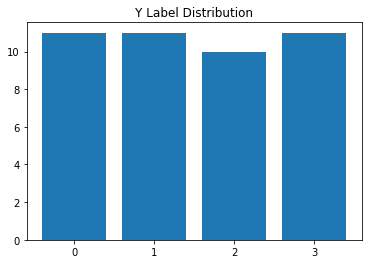

First 5 Labels
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [ ]:
d, k = processor.getProcessedData('train', 1)

print("X Data Shape: ")
print(d.shape)
print("Y Data Shape: ")
print(k.shape)
print("Label Distribution: ")
print(sum(k))

plot_label_distribution(k)

N = 5
print("First {} Labels".format(N))
print(k[:N])

## Inspecting Cropped Data

X Data Shape: 
(645, 7, 6, 313)
Y Data Shape: 
(645, 4)
Label Distribution: 
[165. 165. 150. 165.]


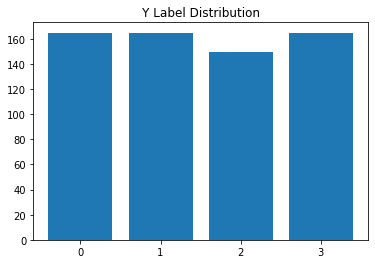

First 5 Labels
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
d, k = processor.getCroppedData('train', 1)

print("X Data Shape: ")
print(d.shape)
print("Y Data Shape: ")
print(k.shape)
print("Label Distribution: ")
print(sum(k))

plot_label_distribution(k)

N = 5
print("First {} Labels".format(N))
print(k[:N])

## Inspecting Averaged Data

X Data Shape: 
(645, 7, 6, 313)
Y Data Shape: 
(645, 4)
Label Distribution: 
[165. 165. 150. 165.]


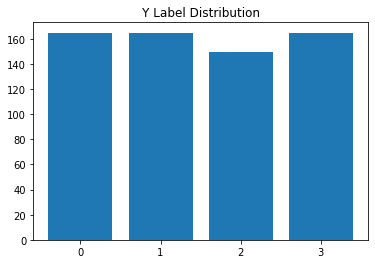

First 5 Labels
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
d, k = processor.getAveragedData('train', 1)

print("X Data Shape: ")
print(d.shape)
print("Y Data Shape: ")
print(k.shape)
print("Label Distribution: ")
print(sum(k))

plot_label_distribution(k)

N = 5
print("First {} Labels".format(N))
print(k[:N])

## Inspecting Shuffled Data

X Data Shape: 
(645, 7, 6, 313)
Y Data Shape: 
(645, 4)
Label Distribution: 
[165. 165. 150. 165.]


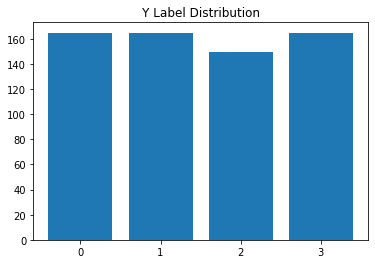

First 5 Labels
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
d, k = processor.getShuffledData('train', 1)

print("X Data Shape: ")
print(d.shape)
print("Y Data Shape: ")
print(k.shape)
print("Label Distribution: ")
print(sum(k))

plot_label_distribution(k)

N = 5
print("First {} Labels".format(N))
print(k[:N])